2022-05-21 15:23:45.210103: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-21 15:23:45.210150: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-21 15:23:46.974317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-21 15:23:46.974362: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-21 15:23:46.974378: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-GC2VT9N): /proc/driver/nvidia/version does not exist
2022-05-21 15:23:46.974762: I tensorflow/core/platform/cpu_fe

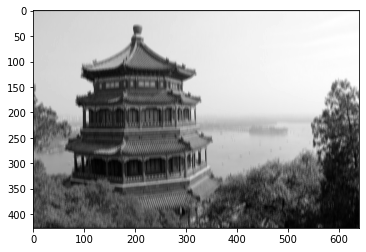

In [1]:
from sklearn.datasets import load_sample_image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255

images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros((7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 0], cmap="gray")
plt.show()


In [4]:
conv = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="SAME", strides=1, activation=tf.nn.relu)

In [5]:

outputs = tf.nn.max_pool(images, ksize=[1, 1, 1, 3], strides=[1, 1, 1, 3], padding="VALID")



In [6]:
depth_pool = tf.keras.layers.Lambda(lambda X: tf.nn.max_pool(X, ksize=[1, 1, 1, 3], strides=[1, 1, 1, 3], padding="VALID"))


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=7, padding="SAME", input_shape=[28, 28, 1], activation=tf.nn.relu
    ),
    tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=[2, 2]),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3,
                          padding="SAME", activation=tf.nn.relu),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3,
                          padding="SAME", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=[2, 2]),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3,
                           padding="SAME", activation=tf.nn.relu),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3,
                           padding="SAME", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=[2, 2]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)
])
